# Étude de l'impact de la réduction des données

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from tqdm.notebook import trange, tqdm

from tools import Modelisation, datasets, convert_keys_to_int, PDF

pdf = PDF('output/reduction_donnees/')

t = time.time()

In [2]:
best_LR = "LR_RFECV"
best_RF = "Forest_RFECV"
best_XGB = "XGBoost_RFECV"

In [3]:
import json

# Régression logistique
with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)[best_LR]
    LR_PARAMS = convert_keys_to_int(LR_PARAMS)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

# Forêt aléatoires
with open('backups/RFECV_Forest.json') as column_file:
    RF_COLUMNS = json.load(column_file)
    RF_COLUMNS_QUANT = RF_COLUMNS['columns_quant']
    RF_COLUMNS_CAT = RF_COLUMNS['columns_cat']
    RF_COLUMNS = RF_COLUMNS_QUANT + RF_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    RF_PARAMS = json.load(param_file)[best_RF]
    RF_PARAMS = convert_keys_to_int(RF_PARAMS)

print(f'Variables explicatives forêt aléatoires ({len(RF_COLUMNS)}) :')
display(RF_COLUMNS)

print(f'Meilleurs paramètres forêt aléatoires ({len(RF_PARAMS)}) :')
RF_PARAMS['class_weight'] = {int(k): v for k,v in RF_PARAMS['class_weight'].items()}
display(RF_PARAMS)

# XGBoost
with open('backups/RFECV_XGBoost.json') as column_file:
    XGB_COLUMNS = json.load(column_file)
    XGB_COLUMNS_QUANT = XGB_COLUMNS['columns_quant']
    XGB_COLUMNS_CAT = XGB_COLUMNS['columns_cat']
    XGB_COLUMNS = XGB_COLUMNS_QUANT + XGB_COLUMNS_CAT

with open('backups/PARAMS_XGBoost.json') as param_file:
    XGB_PARAMS = json.load(param_file)[best_XGB]
    XGB_PARAMS = convert_keys_to_int(XGB_PARAMS)

print(f'Variables explicatives XGBoost ({len(XGB_COLUMNS)}) :')
display(XGB_COLUMNS)

print(f'Meilleurs paramètres XGBoost ({len(XGB_PARAMS)}) :')
display(XGB_PARAMS)

# Seuils ajustés
with open('backups/THRESHOLD.json') as threshold_file:
    SEUILS = json.load(threshold_file)

print("Seuils ajustés :")
display(SEUILS)

Variables explicatives régression logistique (11) :


['campaignctrlast24h',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'campaignscenario_13',
 'device_type_Desktop',
 'device_type_iPhone',
 'display_env_app_ios',
 'is_interstitial_True',
 'target_env_2']

Meilleurs paramètres régression logistique (2) :


{'C': 0.007278953843983146, 'class_weight': {0: 1, 1: 20}}

Variables explicatives forêt aléatoires (9) :


['campaignctrlast24h',
 'contextid',
 'dayssincelastvisitdouble',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêt aléatoires (8) :


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': False,
 'n_jobs': -1}

Variables explicatives XGBoost (9) :


['campaignctrlast24h',
 'contextid',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'device_type_Android',
 'device_type_Desktop',
 'device_type_iPad',
 'is_interstitial_True']

Meilleurs paramètres XGBoost (11) :


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.6,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'n_jobs': -1}

Seuils ajustés :


{'LR': 0.5014648437500001,
 'Forest': 0.6503906250000003,
 'XGBoost': 0.46533203125}

In [4]:
data_frac_list = np.logspace(-3.3, 0, 15)
nb = len(pd.read_csv('data/df_train_prepro.csv'))
print(f"Minimum : {data_frac_list[0]*100:.3f}% soit {data_frac_list[0]*nb:.0f} observations")
print(f"2ème : {data_frac_list[1]*100:.3f}% soit {data_frac_list[1]*nb:.0f} observations")
data_frac_list

Minimum : 0.050% soit 807 observations
2ème : 0.086% soit 1389 observations


array([5.01187234e-04, 8.62410997e-04, 1.48398179e-03, 2.55354113e-03,
       4.39397056e-03, 7.56086404e-03, 1.30102522e-02, 2.23872114e-02,
       3.85224842e-02, 6.62870316e-02, 1.14062492e-01, 1.96271455e-01,
       3.37731391e-01, 5.81146617e-01, 1.00000000e+00])

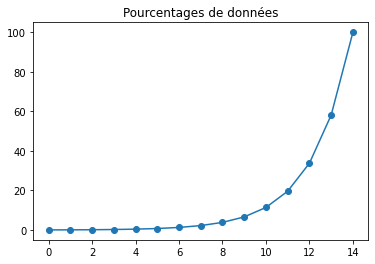

In [5]:
plt.plot(100*data_frac_list, marker='o')
plt.title("Pourcentages de données")
plt.show()

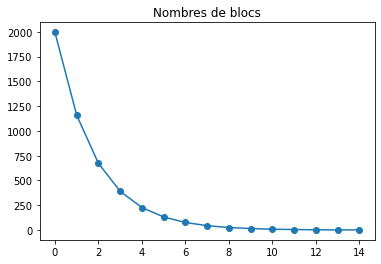

In [6]:
plt.plot([int(1/elem) for elem in data_frac_list], marker='o')
plt.title("Nombres de blocs")
plt.show()

In [7]:
def graph(scores, column='f3'):
    fig, ax = plt.subplots()
    for model_name in scores['model_name'].unique():
        scores_model = scores[scores.model_name == model_name]    
        ax.plot(100*scores_model['data_frac'], scores_model[column], label=model_name, marker='o')
    ax.set_xscale('log')
    ax.set_xlabel("Pourcentage de données")
    ax.set_ylabel(column)
    ax.legend()
    pdf.export()
    plt.show()

In [8]:
def graph_x(scores, column='f3', x_column='training_time'):
    fig, ax = plt.subplots()
    for model_name in scores['model_name'].unique():
        scores_model = scores[scores.model_name == model_name]    
        ax.scatter(scores_model[x_column], scores_model[column], label=model_name, marker='o', s=15)
    ax.set_xlabel(x_column)
    ax.set_ylabel(column)
    ax.legend()
    pdf.export()
    plt.show()

## 1. Régression logistique

In [9]:
df_train_all = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1, random_state=1234)
datasets_df_test = datasets(df_test, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
X_test = datasets_df_test['X_only_quant_scaled']
y_test = datasets_df_test['y']

**Première idée non robuste avec un seul calcul pour chaque pourcentage**

In [10]:
%%time
SCORES_LR = []
for data_frac in tqdm(data_frac_list):
    df_train = df_train_all.sample(frac=data_frac, random_state=1234)
    datasets_df_train = datasets(df_train, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
    X_train = datasets_df_train['X_only_quant_scaled']
    y_train = datasets_df_train['y']

    m = Modelisation(X_train, y_train, LogisticRegression(**LR_PARAMS), X_test=X_test, y_test=y_test, seuil=SEUILS['LR'])

    metrics = m.metrics_score
    metrics['model_name'] = 'Régression logistique'
    metrics['data_frac'] = data_frac
    metrics['training_time'] = m.training_time
    metrics['prediction_time'] = m.prediction_time
    SCORES_LR.append(metrics)
SCORES_LR = pd.DataFrame(SCORES_LR)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 2min 27s, sys: 6min 36s, total: 9min 3s
Wall time: 34.6 s


Export PDF : output/reduction_donnees/00.pdf



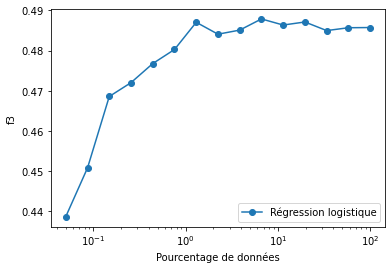

In [11]:
graph(SCORES_LR)

Export PDF : output/reduction_donnees/01.pdf



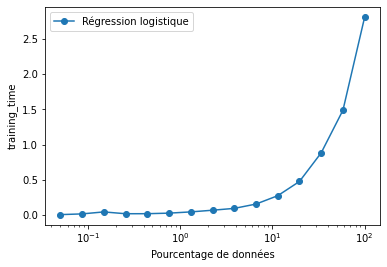

In [12]:
graph(SCORES_LR, column='training_time')

Export PDF : output/reduction_donnees/02.pdf



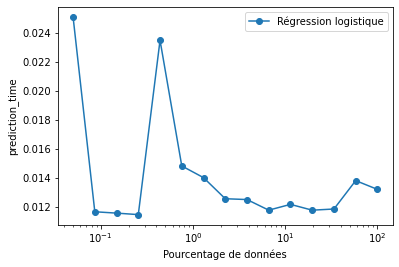

In [13]:
graph(SCORES_LR, column='prediction_time')

**Méthode plus robuste avec moyenne**

In [14]:
%%time
SCORES_LR = []
for data_frac in tqdm(data_frac_list, desc="data_frac loop"):
    nb_blocs = int(1/data_frac)
    df_train_list = np.array_split(df_train_all, nb_blocs)
    scores_frac = []
    for df_train in tqdm(df_train_list, desc="split loop", leave=False):
        datasets_df_train = datasets(df_train, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
        X_train = datasets_df_train['X_only_quant_scaled']
        y_train = datasets_df_train['y']    

        m = Modelisation(X_train, y_train, LogisticRegression(**LR_PARAMS), X_test=X_test, y_test=y_test, seuil=SEUILS['LR'])

        metrics = m.metrics_score
        metrics['data_frac'] = data_frac
        metrics['training_time'] = m.training_time
        metrics['prediction_time'] = m.prediction_time
        scores_frac.append(metrics)
    scores_frac = pd.DataFrame(scores_frac)
    mean = scores_frac.mean()
    mean['model_name'] = 'Régression logistique'
    SCORES_LR.append(mean)
SCORES_LR = pd.DataFrame(SCORES_LR)

data_frac loop:   0%|          | 0/15 [00:00<?, ?it/s]

split loop:   0%|          | 0/1995 [00:00<?, ?it/s]

split loop:   0%|          | 0/1159 [00:00<?, ?it/s]

split loop:   0%|          | 0/673 [00:00<?, ?it/s]

split loop:   0%|          | 0/391 [00:00<?, ?it/s]

split loop:   0%|          | 0/227 [00:00<?, ?it/s]

split loop:   0%|          | 0/132 [00:00<?, ?it/s]

split loop:   0%|          | 0/76 [00:00<?, ?it/s]

split loop:   0%|          | 0/44 [00:00<?, ?it/s]

split loop:   0%|          | 0/25 [00:00<?, ?it/s]

split loop:   0%|          | 0/15 [00:00<?, ?it/s]

split loop:   0%|          | 0/8 [00:00<?, ?it/s]

split loop:   0%|          | 0/5 [00:00<?, ?it/s]

split loop:   0%|          | 0/2 [00:00<?, ?it/s]

split loop:   0%|          | 0/1 [00:00<?, ?it/s]

split loop:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 4h 17min 4s, sys: 14h 30min 40s, total: 18h 47min 44s
Wall time: 57min 3s


Export PDF : output/reduction_donnees/03.pdf



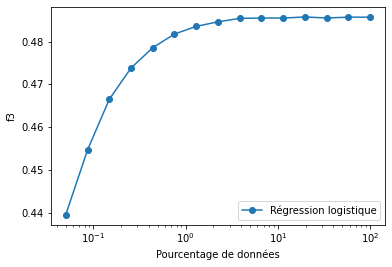

In [15]:
graph(SCORES_LR)

Export PDF : output/reduction_donnees/04.pdf



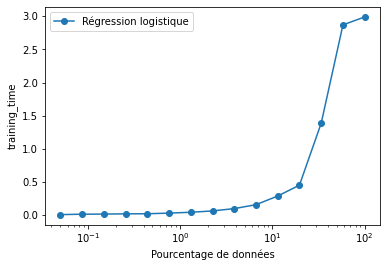

In [16]:
graph(SCORES_LR, column='training_time')

Export PDF : output/reduction_donnees/05.pdf



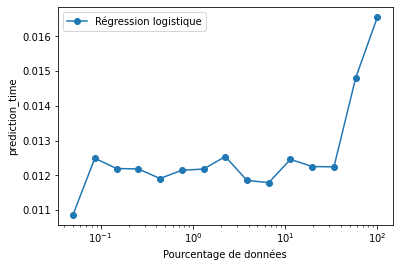

In [17]:
graph(SCORES_LR, column='prediction_time')

Export PDF : output/reduction_donnees/06.pdf



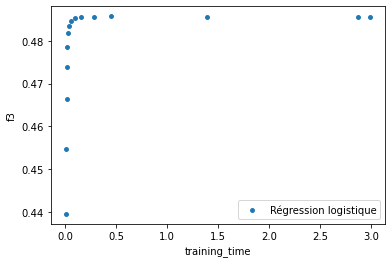

In [18]:
graph_x(SCORES_LR)

Export PDF : output/reduction_donnees/07.pdf



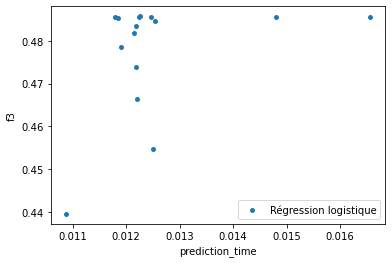

In [19]:
graph_x(SCORES_LR, x_column='prediction_time')

## 2. Random Forest

In [20]:
df_train_all = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1, random_state=1234)
datasets_df_test = datasets(df_test, columns_quant=RF_COLUMNS_QUANT, columns_cat=RF_COLUMNS_CAT, verbose=False)
X_test = datasets_df_test['X']
y_test = datasets_df_test['y']

In [21]:
%%time
SCORES_RF = []
for data_frac in tqdm(data_frac_list, desc="data_frac loop"):
    nb_blocs = int(1/data_frac)
    df_train_list = np.array_split(df_train_all, nb_blocs)
    scores_frac = []
    for df_train in tqdm(df_train_list, desc="split loop", leave=False):
        datasets_df_train = datasets(df_train, columns_quant=RF_COLUMNS_QUANT, columns_cat=RF_COLUMNS_CAT, verbose=False)
        X_train = datasets_df_train['X']
        y_train = datasets_df_train['y']    

        m = Modelisation(X_train, y_train, RandomForestClassifier(**RF_PARAMS), X_test=X_test, y_test=y_test, seuil=SEUILS['Forest'])

        metrics = m.metrics_score
        metrics['data_frac'] = data_frac
        metrics['training_time'] = m.training_time
        metrics['prediction_time'] = m.prediction_time
        scores_frac.append(metrics)
    scores_frac = pd.DataFrame(scores_frac)
    mean = scores_frac.mean()
    mean['model_name'] = 'Random Forest'
    SCORES_RF.append(mean)
SCORES_RF = pd.DataFrame(SCORES_RF)

data_frac loop:   0%|          | 0/15 [00:00<?, ?it/s]

split loop:   0%|          | 0/1995 [00:00<?, ?it/s]

split loop:   0%|          | 0/1159 [00:00<?, ?it/s]

split loop:   0%|          | 0/673 [00:00<?, ?it/s]

split loop:   0%|          | 0/391 [00:00<?, ?it/s]

split loop:   0%|          | 0/227 [00:00<?, ?it/s]

split loop:   0%|          | 0/132 [00:00<?, ?it/s]

split loop:   0%|          | 0/76 [00:00<?, ?it/s]

split loop:   0%|          | 0/44 [00:00<?, ?it/s]

split loop:   0%|          | 0/25 [00:00<?, ?it/s]

split loop:   0%|          | 0/15 [00:00<?, ?it/s]

split loop:   0%|          | 0/8 [00:00<?, ?it/s]

split loop:   0%|          | 0/5 [00:00<?, ?it/s]

split loop:   0%|          | 0/2 [00:00<?, ?it/s]

split loop:   0%|          | 0/1 [00:00<?, ?it/s]

split loop:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2d 17h 17min, sys: 1h 7min 8s, total: 2d 18h 24min 9s
Wall time: 5h 2min 46s


Export PDF : output/reduction_donnees/08.pdf



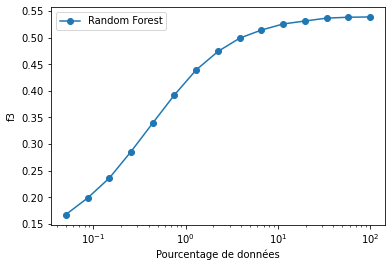

In [22]:
graph(SCORES_RF)

Export PDF : output/reduction_donnees/09.pdf



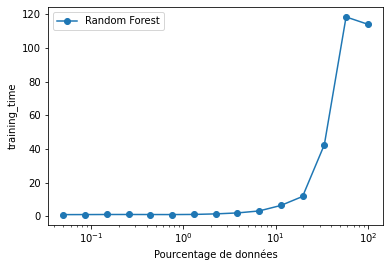

In [23]:
graph(SCORES_RF, column='training_time')

Export PDF : output/reduction_donnees/10.pdf



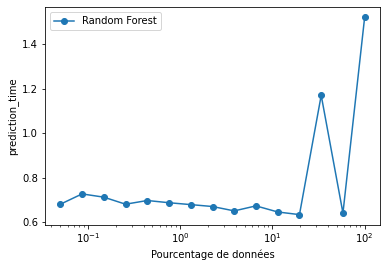

In [24]:
graph(SCORES_RF, column='prediction_time')

Export PDF : output/reduction_donnees/11.pdf



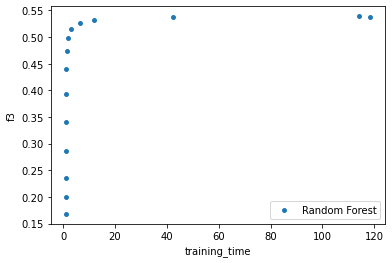

In [25]:
graph_x(SCORES_RF)

Export PDF : output/reduction_donnees/12.pdf



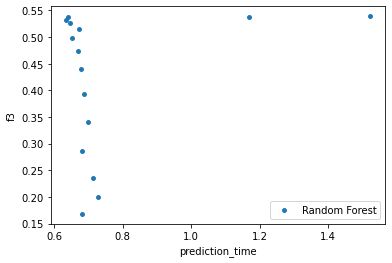

In [26]:
graph_x(SCORES_RF, x_column='prediction_time')

## 3. XGBoost

In [27]:
df_train_all = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1, random_state=1234)
datasets_df_test = datasets(df_test, columns_quant=XGB_COLUMNS_QUANT, columns_cat=XGB_COLUMNS_CAT, verbose=False)
X_test = datasets_df_test['X']
y_test = datasets_df_test['y']

In [28]:
%%time
SCORES_XGB = []
for data_frac in tqdm(data_frac_list, desc="data_frac loop"):
    nb_blocs = int(1/data_frac)
    df_train_list = np.array_split(df_train_all, nb_blocs)
    scores_frac = []
    for df_train in tqdm(df_train_list, desc="split loop", leave=False):
        datasets_df_train = datasets(df_train, columns_quant=XGB_COLUMNS_QUANT, columns_cat=XGB_COLUMNS_CAT, verbose=False)
        X_train = datasets_df_train['X']
        y_train = datasets_df_train['y']    

        m = Modelisation(X_train, y_train, XGBClassifier(**XGB_PARAMS), X_test=X_test, y_test=y_test, seuil=SEUILS['XGBoost'])

        metrics = m.metrics_score
        metrics['data_frac'] = data_frac
        metrics['training_time'] = m.training_time
        metrics['prediction_time'] = m.prediction_time
        scores_frac.append(metrics)
    scores_frac = pd.DataFrame(scores_frac)
    mean = scores_frac.mean()
    mean['model_name'] = 'XGBoost'
    SCORES_XGB.append(mean)
SCORES_XGB = pd.DataFrame(SCORES_XGB)

data_frac loop:   0%|          | 0/15 [00:00<?, ?it/s]

split loop:   0%|          | 0/1995 [00:00<?, ?it/s]

split loop:   0%|          | 0/1159 [00:00<?, ?it/s]

split loop:   0%|          | 0/673 [00:00<?, ?it/s]

split loop:   0%|          | 0/391 [00:00<?, ?it/s]

split loop:   0%|          | 0/227 [00:00<?, ?it/s]

split loop:   0%|          | 0/132 [00:00<?, ?it/s]

split loop:   0%|          | 0/76 [00:00<?, ?it/s]

split loop:   0%|          | 0/44 [00:00<?, ?it/s]

split loop:   0%|          | 0/25 [00:00<?, ?it/s]

split loop:   0%|          | 0/15 [00:00<?, ?it/s]

split loop:   0%|          | 0/8 [00:00<?, ?it/s]

split loop:   0%|          | 0/5 [00:00<?, ?it/s]

split loop:   0%|          | 0/2 [00:00<?, ?it/s]

split loop:   0%|          | 0/1 [00:00<?, ?it/s]

split loop:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2d 3h 43min 52s, sys: 5min 47s, total: 2d 3h 49min 40s
Wall time: 1h 51min 40s


Export PDF : output/reduction_donnees/13.pdf



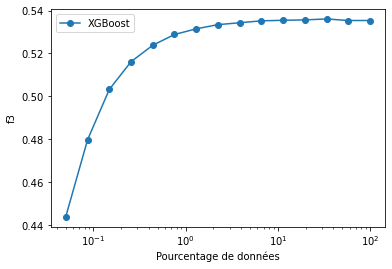

In [29]:
graph(SCORES_XGB)

Export PDF : output/reduction_donnees/14.pdf



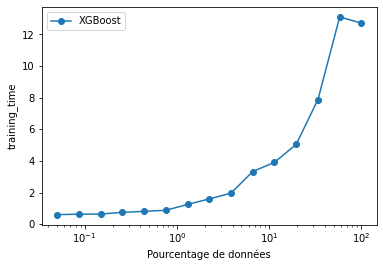

In [30]:
graph(SCORES_XGB, column='training_time')

Export PDF : output/reduction_donnees/15.pdf



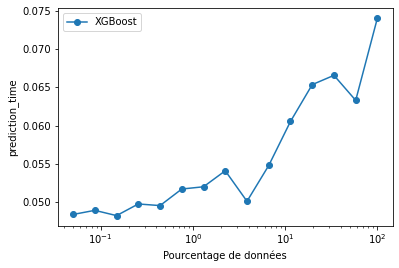

In [31]:
graph(SCORES_XGB, column='prediction_time')

Export PDF : output/reduction_donnees/16.pdf



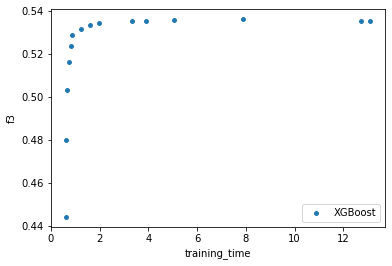

In [32]:
graph_x(SCORES_XGB)

Export PDF : output/reduction_donnees/17.pdf



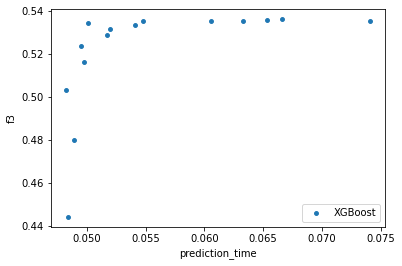

In [33]:
graph_x(SCORES_XGB, x_column='prediction_time')

## 4. Comparaison

In [34]:
df_concat = pd.concat([SCORES_LR, SCORES_RF, SCORES_XGB])

Export PDF : output/reduction_donnees/18.pdf



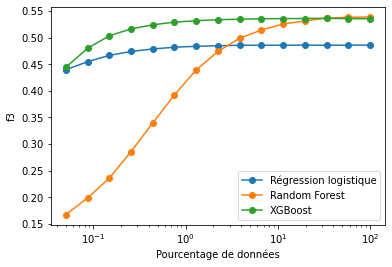

In [35]:
graph(df_concat)

Export PDF : output/reduction_donnees/19.pdf



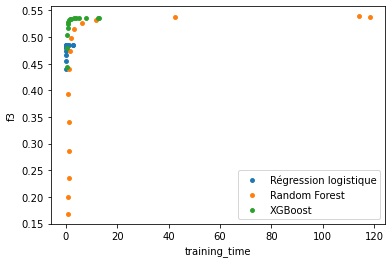

In [36]:
graph_x(df_concat)

Export PDF : output/reduction_donnees/20.pdf



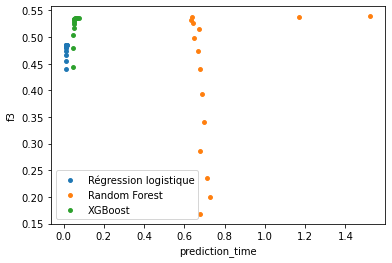

In [37]:
graph_x(df_concat, x_column='prediction_time')

In [38]:
df_concat.to_csv('backups/SCORES_reduction_donnees.csv')

In [39]:
print(f"Durée totale d'exécution : {time.strftime('%H:%M:%S', time.gmtime(time.time() - t))}")

Durée totale d'exécution : 07:53:26
